In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

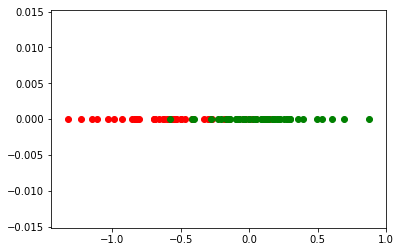

In [54]:

random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append([x+s*math.cos(theta)])
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,x,r))
    return clusters

n = 50
X = rand_clusters(2,50,0.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n]))
# label = np.array([1]*n + [0]*n)
# print (data, label)

plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [139]:
# tf.reset_default_graph()

# def weight_variable(shape, name):
#     initial = tf.truncated_normal(shape=shape, stddev=0.1)
#     return tf.get_variable(name=name, initializer=initial)

# def bias_variable(shape, name):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 2
n_output = 1
lmd = 0

parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.zeros([n_hidden]),\
                                    tf.truncated_normal([n_hidden * n_output]), tf.zeros([n_output]),\
                                   ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.nn.relu(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.relu(tf.matmul(hidden, weights2) + biases2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [145]:

def get_accuracy():
    pred = sess.run(y, feed_dict={x: data, y_: label})    
    match = [(pred[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad():
    nng = 0.
    for gv in grad:
#         print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        g = sess.run(gv, feed_dict={x: data, y_: label})
        print (g)
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()


In [148]:
# 太巧合了！ 绝对不能改！
w0 = np.array([1,0.4,
              0.1,0.5,
              1,1,
              1])
private_init = parameters.assign(w0)

sess = tf.InteractiveSession()
l = 0.5
dic = {}
for _ in range(1):

    tf.global_variables_initializer().run()
    sess.run(private_init)    
    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
    nng = get_norm_grad()
#     print (w)

    for i in range(10):
        sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
        
#         if i % 1 == 0:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
        nng = get_norm_grad()
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
        print (w)
#             h = sess.run([y], feed_dict={x: data, y_: label})    
#             print (h)
sess.close() 

[ 0.00291572  0.04794232  0.00354564 -0.06744069  0.03270284 -0.1454341
 -0.69240677]
[ 0.00753453  0.05919332  0.03412173  0.0119173   0.13001086  0.16569825
  0.06899914]
Epoch 1, accuracy 30.00%, loss 0.282744, nng 0.2324, nnw 1.067, high_eig 2.533, low_eig -0.3944.
[ 0.99854213  0.37602884  0.09822718  0.53372037  0.08364858  0.17271705
  0.44620338]
[ 0.00133986  0.03195352  0.00543898 -0.00819002  0.0951729   0.07508073
 -0.09113387]
Epoch 2, accuracy 49.00%, loss 0.264211, nng 0.1553, nnw 1.053, high_eig 2.465, low_eig -0.3303.
[ 0.99477488  0.34643218  0.08116631  0.5277617   0.01864315  0.08986793
  0.41170382]
[-0.00206628  0.01744991 -0.00875153 -0.00230922  0.09468969  0.08672758
 -0.04413009]
Epoch 3, accuracy 50.00%, loss 0.253172, nng 0.1372, nnw 1.048, high_eig 2.47, low_eig -0.3104.
[ 0.99410492  0.33045542  0.07844682  0.53185672 -0.0289433   0.05232756
  0.45727077]
[-0.00507562  0.00289519 -0.02196248 -0.00045719  0.0900524   0.07672898
 -0.05100465]
Epoch 4, accura